In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

file = gc.open('Operator vs Managed System')
worksheet = file.get_worksheet(0) # get first sheet containing links to repo
print(worksheet)

<Worksheet 'Source' id:0>


In [ ]:
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(rows)

In [ ]:
operators = df.iloc[2:, :2].reset_index(drop=True)
operators.columns = ["Name", "Repo"]

managed_systems = df.iloc[2:, 6:8].reset_index(drop=True)
managed_systems.columns = ["Name", "Repo"]

In [ ]:
!npm install -g cloc

/tools/node/bin/cloc -> /tools/node/lib/node_modules/cloc/lib/cloc
+ cloc@2.0.0-cloc
added 1 package from 1 contributor in 0.717s


In [ ]:
%mkdir -p repos

In [ ]:
import io
import os
from os import path
import subprocess

In [ ]:
def clone_repo(dirname: str, repo_addr: str):
    if os.path.exists(f"./repos/{dirname}"):
        return
    subprocess.run(args=["git", "clone", "--depth", "1", repo_addr, dirname],
                   cwd="./repos", check=True)

def cloc(path: str, exclude_dirs=[".git", ".github", "docs", "doc"]):
    exclude_dirs_str = "--exclude-dir=" + ",".join(exclude_dirs)
    print(exclude_dirs_str)
    res = subprocess.run(args=["cloc", "--csv", ".", exclude_dirs_str],
                         cwd=path, check=True,
                         capture_output=True)
    data_str = str(res.stdout).split("\\n", 1)[1].replace("\\n", "\n")[:-1]
    df = pd.read_csv(io.StringIO(data_str),
                     names=["files", "language", "blank", "comment", "code"])
    return df

def cloc2(path: str, args: list[str]):
    res = subprocess.run(args=["cloc", "--csv", ".", *args],
                         cwd=path, check=True,
                         capture_output=True)
    data_str = str(res.stdout).split("\\n", 1)[1].replace("\\n", "\n")[:-1]
    df = pd.read_csv(io.StringIO(data_str),
                     names=["files", "language", "blank", "comment", "code"])
    return df

In [ ]:
from tqdm import tqdm

for _, (name, repo) in tqdm(operators.iterrows()):
    clone_repo(name, repo)

54it [01:06,  1.23s/it]


In [ ]:
import yaml
import glob

def read_yaml_file(filename):
    with open(filename, 'r') as stream:
        try:
            print(yaml.safe_load(stream))
        except yaml.YAMLError as exc:
            print(exc)


def get_yaml_stats(dirname: str):
    files = glob.glob(f"{dirname}/*.yaml") # list of all .yaml files in a directory

    for file in files:
        read_yaml_file(file)

In [ ]:
!cloc ./repos/argocd-operator/ --include-content "CustomResourceDefinition" --include-lang yaml --by-file

     742 text files.
      83 unique files.                              
     657 files ignored.

github.com/AlDanial/cloc v 2.00  T=1.05 s (77.0 files/s, 224859.5 lines/s)
----------------------------------------------------------------------------------------------------------------------------------------------------------------
File                                                                                                                         blank        comment           code
----------------------------------------------------------------------------------------------------------------------------------------------------------------
./repos/argocd-operator/deploy/olm-catalog/argocd-operator/0.9.0/argoproj.io_applicationsets.yaml                                0              0          15245
./repos/argocd-operator/config/crd/bases/argoproj.io_applicationsets.yaml                                                        0              0          15238
./repos/argocd-operat

In [ ]:
i = 0
for name in operators["Name"]:
    repo_path = f"./repos/{name}"
    for node in os.listdir(repo_path):
        node_path = path.join(f"./repos/{name}", node)
        if path.isdir(node_path) and 'test' in node:
            print(name, node)
            i += 1
i

argocd-operator tests
bookkeeper-operator test
cassandra-operator test
rook-ceph tests
clickhouse-operator tests
falcon-operator test
cloud-on-k8s test
flink-kubernetes-operator e2e-tests
grafana-operator tests
cass-operator tests
strimzi-kafka-operator systemtest
strimzi-kafka-operator test
koperator tests
knative operator test
kubeblocks test
kubeblocks test
minio-operator tests
minio-operator testing
mongodb-operator test
mongodb-operator testdata
percona-server-mongodb-operator e2e-tests
mysql-operator tests
percona-server-mysql-operator e2e-tests
crunchy-data-postgres-operator testing
cloudnative-pg tests
percona-postgresql-operator e2e-tests
percona-postgresql-operator testing
prometheus-operator test
kubeblocks test
cluster-operator system_tests
spotahome-redis-operator test
ot-container-kit-redis-operator tests
scylla-operator test
solr-operator tests
tidb-operator tests
trivy-operator tests
vitess-operator test
zookeeper-operator test
splunk-operator test
kuberflow-training-op

46

In [ ]:
stats = pd.concat([
    cloc2(f"./repos/{name}", ["--exclude-dir=.git,.github,.docs,.doc"])\
        .set_index("language")[["blank", "comment", "code"]]\
        .sum(axis=1)
    for name in tqdm(operators["Name"])
], axis=1).T

100%|██████████| 54/54 [04:43<00:00,  5.26s/it]


In [ ]:
stats_yaml_crd = pd.concat([
    cloc2(f"./repos/{name}", ["--include-content=CustomResourceDefinition", "--include-lang=yaml"])\
        .set_index("language")[["blank", "comment", "code"]]\
        .sum(axis=1)
    for name in tqdm(operators["Name"])
], axis=1).T
stats_yaml_no_crd = pd.concat([
    cloc2(f"./repos/{name}", ["--exclude-content=CustomResourceDefinition", "--include-lang=yaml"])\
        .set_index("language")[["blank", "comment", "code"]]\
        .sum(axis=1)
    for name in tqdm(operators["Name"])
], axis=1).T

100%|██████████| 54/54 [00:52<00:00,  1.02it/s]


In [ ]:
print(stats_yaml_crd.head())
print(stats_yaml_no_crd.head())

language    YAML     SUM
0           4383    4383
1         236550  236550
2          12929   12929
3           9034    9034
4           3017    3017
language    YAML     SUM
0         100406  100406
1          31904   31904
2           2161    2161
3            958     958
4           1715    1715


In [ ]:
stats["YAML (CRD)"] = stats_yaml_crd["YAML"]
stats["YAML (not CRD)"] = stats_yaml_no_crd["YAML"]
stats.drop(columns=["YAML"], inplace=True)

In [ ]:
stats = stats[[*sorted(set(stats.columns) - {"SUM"})]]
stats["SUM"] = stats.sum(axis=1)

In [ ]:
operators_processed = pd.concat(
    [
        operators.reset_index(drop=True),
        stats.fillna(value=0)
    ],
    axis=1)
operators_processed.drop_duplicates("Repo", inplace=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
programming_langs = [
    "Go",
    "C++",
    "C/C++ Header",
    "Java",
    "C",
    "JavaScript",
    "Python",
    "TypeScript",
    "Bourne Shell",
    "SQL",
    "Scala",
    "Perl",
    "Assembly",
    "Pascal",
    "Erlang",
    "Elixir",
    "Ruby",
    "C#",
    "Cython",
    "Lisp",
    "ReasonML",
    "Lua",
    "Swift",
    "PHP",
    "NAnt script",
    "PowerShell",
    "Smalltalk",
    "Clojure",
    "Rust",
    "R",
    "ReScript",
    "Objective-C++",
    "SQL Stored Procedure",
    "F#",
    "Korn Shell",
    "D",
    "Nix",
    "Kotlin",
    "CoffeeScript",
    "Visual Basic",
    "JSX",
    "Objective-C",
    "Visual Basic Script",
    "C Shell",
    "ASP.NET",
    "Ada",
    "CUDA",
    "Vuejs Component",
]

config_langs = [
    "YAML",
    "JSON",
    "XML",
    "JSON5",
]

other_langs = [
    "PO File",
    "Markdown",
    "HTML",
    "AsciiDoc",
    "SVG",
    "m4",
    "reStructuredText",
    "CMake",
    "Bazel",
    "yacc",
    "CSS",
    "Tcl/Tk",
    "make",
    "Protocol Buffers",
    "IDL",
    "Maven",
    "Meson",
    "Starlark",
    "Sass",
    "CSV",
    "Bourne Again Shell",
    "lex",
    "MSBuild script",
    "Gradle",
    "Windows Module Definition",
    "TOML",
    "ANTLR Grammar",
    "XSLT",
    "diff",
    "Puppet",
    "Windows Resource File",
    "Dockerfile",
    "LESS",
    "Groovy",
    "DOS Batch",
    "EJS",
    "TeX",
    "HCL",
    "Visual Studio Solution",
    "Ant",
    "INI",
    "ERB",
    "Freemarker Template",
    "Softbridge Basic",
    "SWIG",
    "Stylus",
    "DTD",
    "Jam",
    "Logos",
    "Pug",
    "awk",
    "WiX source",
    "Cucumber",
    "XSD",
    "Gencat NLS",
    "LLVM IR",
    "Velocity Template Language",
    "zsh",
    "Smarty",
    "WiX include",
    "Jupyter Notebook",
    "Thrift",
    "Windows Message File",
    "Handlebars",
    "vim script",
    "Mako",
    "dtrace",
    "XMI",
    "Mustache",
    "WiX string localization",
    "Qt Project",
    "sed",
    "Specman e",
    "SAS",
    "Expect",
    "Fortran 77",
]

all_langs = list(set(operators_processed.columns) - {'Name', 'Repo', 'SUM'})

In [ ]:
operators_processed.columns

Index(['Name', 'Repo', 'ANTLR Grammar', 'AsciiDoc', 'Assembly', 'Bazel',
       'Bourne Again Shell', 'Bourne Shell', 'C', 'C#', 'C++', 'C/C++ Header',
       'CSS', 'CSV', 'DOS Batch', 'Dockerfile', 'Go', 'Gradle', 'Groovy',
       'HCL', 'HTML', 'INI', 'JSON', 'Java', 'JavaScript', 'Jupyter Notebook',
       'Kotlin', 'LESS', 'Lua', 'MSBuild script', 'Markdown', 'Maven',
       'NAnt script', 'PO File', 'PlantUML', 'PowerShell', 'Properties',
       'Protocol Buffers', 'Pug', 'Python', 'Ruby', 'SCSS', 'SQL', 'SVG',
       'Starlark', 'TOML', 'TeX', 'Text', 'TypeScript', 'Vuejs Component',
       'XMI', 'XML', 'YAML (CRD)', 'YAML (not CRD)', 'awk', 'make',
       'reStructuredText', 'sed', 'zsh', 'SUM'],
      dtype='object')

In [ ]:
# popular_langs

langs_sorted = [
    'Go',
    'Java',
    'Python',

    'YAML (CRD)',
    'YAML (not CRD)',
    'JSON',

    'Markdown',
    'Text',
    'AsciiDoc',

    'Bourne Shell',
    'Bourne Again Shell',

    'Protocol Buffers',
    'SQL',
    'PO File',

    'Assembly',
    'Vuejs Component',
    'TypeScript',
    'JavaScript',
    'HTML',

    'make',
    'Maven'
    ]

In [ ]:
data

,Go,Java,Python,YAML (CRD),YAML (not CRD),JSON,Markdown,Text,AsciiDoc,Bourne Shell,...,SQL,PO File,Assembly,Vuejs Component,TypeScript,JavaScript,HTML,make,Maven,Other Files
Name,,,,,,,,,,,,,,,,,,,,,
container-security-operator,6754.0,0.0,0.0,254,304,0.0,132.0,0.0,0.0,230.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,42.0
cassandra-operator,5832.0,528.0,0.0,3017,1715,0.0,47.0,5.0,0.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.0,129.0,219.0
mysql-operator,0.0,0.0,12412.0,1099,1407,0.0,437.0,61.0,0.0,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0
authorino-operator,2974.0,0.0,0.0,12929,2161,0.0,390.0,15.0,0.0,210.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,0.0,50.0
bookkeeper-operator,7919.0,0.0,0.0,9034,958,0.0,950.0,15.0,0.0,134.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0,77.0
flinkk8soperator,16400.0,350.0,29.0,1135,491,0.0,809.0,5.0,0.0,626.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,74.0,212.0
rocketmq-operator,3915.0,0.0,0.0,14556,1425,0.0,1294.0,15.0,0.0,934.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249.0,0.0,258.0
zookeeper-operator,7531.0,0.0,0.0,12476,1460,0.0,706.0,15.0,0.0,641.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,0.0,313.0
cluster-operator,18554.0,0.0,0.0,5045,4560,116.0,2440.0,390.0,622.0,515.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,241.0,0.0,47.0


from matplotlib import pyplot as plt
_df_0['Go'].plot(kind='hist', bins=20, title='Go')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Java'].plot(kind='hist', bins=20, title='Java')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Python'].plot(kind='hist', bins=20, title='Python')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['YAML (CRD)'].plot(kind='hist', bins=20, title='YAML (CRD)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Go', y='Java', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Java', y='Python', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Python', y='YAML (CRD)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='YAML (CRD)', y='YAML (not CRD)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Go'].plot(kind='line', figsize=(8, 4), title='Go')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Java'].plot(kind='line', figsize=(8, 4), title='Java')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Python'].plot(kind='line', figsize=(8, 4), title='Python')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['YAML (CRD)'].plot(kind='line', figsize=(8, 4), title='YAML (CRD)')
plt.gca().spines[['top', 'right']].set_visible(False)

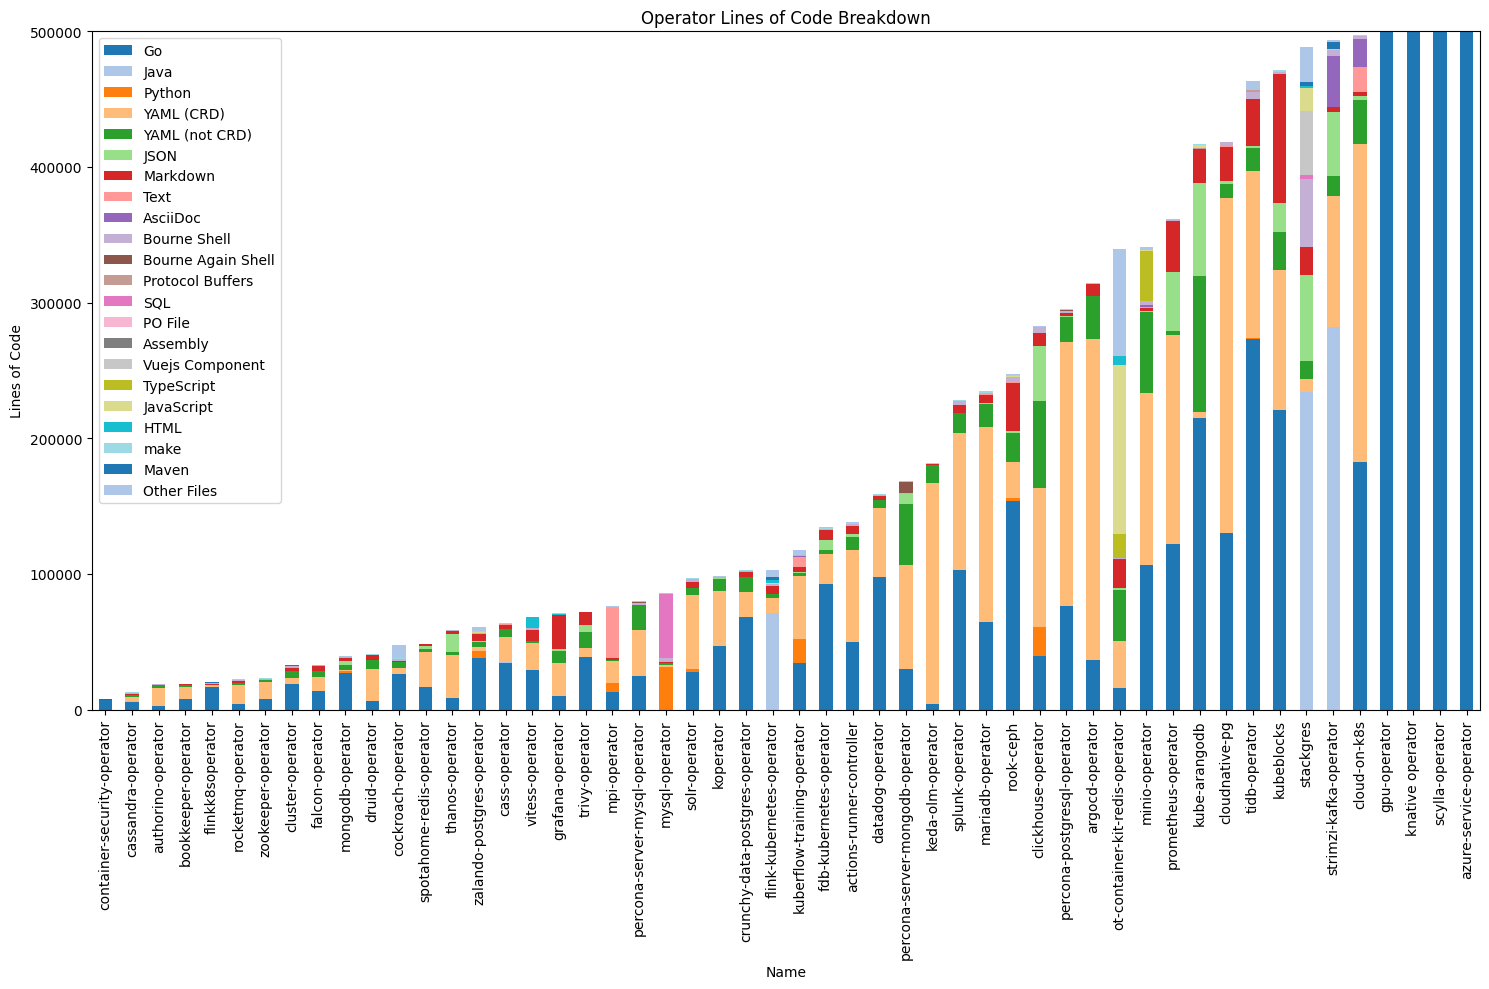

In [ ]:
# operator loc break down
data = operators_processed.copy()
data.set_index("Name", inplace=True)
data.sort_values("SUM", inplace=True)
popular_langs = data[all_langs].sum(axis=0).sort_values(ascending=False)[:20].index.to_list()
data[all_langs].sum(axis=0).sort_values(ascending=False)[20:].index.to_list()
rest_langs = set(all_langs) - set(langs_sorted)
data["Other Files"] = data[list(rest_langs)].sum(axis=1)
# print(data.loc["flink-kubernetes-operator"].to_string())
data = data[[*langs_sorted, "Other Files"]]
# data.columns = ["Programming Languages", "Configuration Files", "Other Files"]
data.plot.bar(stacked=True, figsize=(15, 10), color=sns.color_palette("tab20"))
plt.ylim(0, 5e5)
plt.xticks(rotation=90)
plt.title("Operator Lines of Code Breakdown")
plt.ylabel("Lines of Code")
# plt.yscale("log")
plt.tight_layout()
plt.savefig("operator-loc-breakdown.png", dpi=300, bbox_inches="tight")

In [ ]:
# project size
operators_processed["SUM"].describe()

count    5.200000e+01
mean     3.700822e+05
std      7.756742e+05
min      7.755000e+03
25%      5.619875e+04
50%      1.066075e+05
75%      3.297462e+05
max      4.290334e+06
Name: SUM, dtype: float64

In [ ]:
# main language loc percentage
(operators_processed[["Java", "Python", "Go"]].sum(axis=1) / operators_processed["SUM"]).describe()

count    54.000000
mean      0.445312
std       0.221598
min       0.024168
25%       0.295129
50%       0.444883
75%       0.596085
max       0.894376
dtype: float64

In [ ]:
df.value_counts()

Kind                            
"ClickHouseInstallation             197
ConfigMap                           125
Service                             122
CustomResourceDefinition             99
StatefulSet                          85
ClickHouseInstallation               76
Pod                                  72
Endpoint                             68
PersistentVolumeClaim                68
Event                                68
"ClickHouseInstallationTemplate      62
description                          59
ClickHouseOperatorConfiguration      52
ClickHouseInstallationTemplate       51
Secret                               22
ClusterServiceVersion                22
ServiceAccount                       17
PodDisruptionBudget                  13
ClickHouseKeeperInstallation         12
"ClickHouseKeeperInstallation        12
type                                 10
Deployment                           10
ClusterRole                          10
StorageClass                          9
Grafana

In [ ]:
!cloc ./repos/strimzi-kafka-operator/ --include-content "CustomResourceDefinition" --include-lang yaml --by-file --exclude-dir "test"

    1885 text files.
      64 unique files.                              
    1893 files ignored.

github.com/AlDanial/cloc v 1.98  T=0.74 s (57.1 files/s, 81729.2 lines/s)
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
File                                                                                                                                 blank        comment           code
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
./repos/strimzi-kafka-operator/packaging/helm-charts/helm3/strimzi-kafka-operator/crds/040-Crd-kafka.yaml                                2              0           6686
./repos/strimzi-kafka-operator/packaging/install/cluster-operator/040-Crd-kafka.yaml                                                     2             

In [ ]:
!cloc ./repos/strimzi-kafka-operator/ --include-content "CustomResourceDefinition" --include-lang yaml --by-file

    2542 text files.
      90 unique files.                              
    2531 files ignored.

github.com/AlDanial/cloc v 1.98  T=3.38 s (14.5 files/s, 28031.0 lines/s)
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
File                                                                                                                                      blank        comment           code
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
./repos/strimzi-kafka-operator/systemtest/src/test/resources/tracing/cert-manager.yaml                                                        1            198          17130
./repos/strimzi-kafka-operator/systemtest/src/test/resources/tracing/jaeger-operator.yaml                                          

In [ ]:
operators

,Name,Repo
2,kube-arangodb,https://github.com/arangodb/kube-arangodb
3,argocd-operator,https://github.com/argoproj-labs/argocd-operator
4,authorino-operator,https://github.com/Kuadrant/authorino-operator
5,bookkeeper-operator,https://github.com/pravega/bookkeeper-operator
6,cassandra-operator,https://github.com/instaclustr/cassandra-operator
7,rook-ceph,https://github.com/rook/rook
8,clickhouse-operator,https://github.com/Altinity/clickhouse-operator
9,cockroach-operator,https://github.com/cockroachdb/cockroach-operator
10,falcon-operator,https://github.com/CrowdStrike/falcon-operator
11,datadog-operator,https://github.com/DataDog/datadog-operator


In [ ]:
data.columns

Index(['Go', 'Java', 'Python', 'YAML (CRD)', 'YAML (not CRD)', 'JSON',
       'Markdown', 'Text', 'AsciiDoc', 'Bourne Shell', 'Bourne Again Shell',
       'Protocol Buffers', 'SQL', 'PO File', 'Assembly', 'Vuejs Component',
       'TypeScript', 'JavaScript', 'HTML', 'make', 'Maven', 'Other Files'],
      dtype='object')

In [ ]:
data.to_csv("operator_loc.csv")

In [ ]:
def extract_kind_from_yaml(directory):
    crd_list = []
    for filepath in glob.glob(f"{directory}/**/*.yaml", recursive=True):
        with open(filepath, 'r') as file:
            try:
                for yaml_content in yaml.load_all(file, yaml.Loader):
                    if isinstance(yaml_content, list):
                        continue
                    # print(yaml_content)
                    if yaml_content and yaml_content.get("kind") == "CustomResourceDefinition":
                        crd_list.append([yaml_content['metadata']['name'], filepath])
            except yaml.YAMLError:
                continue
    return crd_list

def create_dataframe_from_kinds(kind_list):
    df = pd.DataFrame(kind_list, columns=['crd_name', 'filepath'])
    return df

# Replace 'path_to_directory' with the path to your directory containing Kubernetes YAML files
directory = './repos/strimzi-kafka-operator'

kind_list = extract_kind_from_yaml(directory)
df = create_dataframe_from_kinds(kind_list)
# print(df)

                                crd_name  \
0       kafkaconnectors.kafka.strimzi.io   
1       kafkarebalances.kafka.strimzi.io   
2          kafkabridges.kafka.strimzi.io   
3        kafkanodepools.kafka.strimzi.io   
4    kafkamirrormaker2s.kafka.strimzi.io   
..                                   ...   
107              kafkas.kafka.strimzi.io   
108   kafkamirrormakers.kafka.strimzi.io   
109          kafkausers.kafka.strimzi.io   
110       strimzipodsets.core.strimzi.io   
111         kafkatopics.kafka.strimzi.io   

                                              filepath  
0    ./repos/strimzi-kafka-operator/helm-charts/hel...  
1    ./repos/strimzi-kafka-operator/helm-charts/hel...  
2    ./repos/strimzi-kafka-operator/helm-charts/hel...  
3    ./repos/strimzi-kafka-operator/helm-charts/hel...  
4    ./repos/strimzi-kafka-operator/helm-charts/hel...  
..                                                 ...  
107  ./repos/strimzi-kafka-operator/packaging/insta...  
108  ./repos/st

# Excluding Test Folders

In [ ]:
!cloc ./repos/ --include-content "kuttl.dev" --include-lang yaml --by-file

   71932 text files.
     826 unique files.                              
   72210 files ignored.

github.com/AlDanial/cloc v 2.00  T=56.51 s (14.5 files/s, 452.2 lines/s)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
File                                                                                                                                                 blank        comment           code
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
./repos/percona-server-mysql-operator/e2e-tests/tests/limits/01-assert.yaml                                                                              0              0            401
./repos/percona-server-mysql-operator/e2e-tests/tests/limits/03-assert.yaml             

In [ ]:
find ./repos -f

In [ ]:
ls -R repos/argocd-operator/tests/

repos/argocd-operator/tests/:
auxiliary/  config/  ha/  k8s/  kuttl-tests.yaml  ocp/  olm/

repos/argocd-operator/tests/auxiliary:
smtplistener/

repos/argocd-operator/tests/auxiliary/smtplistener:
cmd/  conf.json  Dockerfile  go.mod  go.sum  internal/

repos/argocd-operator/tests/auxiliary/smtplistener/cmd:
listener/

repos/argocd-operator/tests/auxiliary/smtplistener/cmd/listener:
main.go  root.go  serve.go

repos/argocd-operator/tests/auxiliary/smtplistener/internal:
processor/  util/

repos/argocd-operator/tests/auxiliary/smtplistener/internal/processor:
filewriter.go

repos/argocd-operator/tests/auxiliary/smtplistener/internal/util:
util.go

repos/argocd-operator/tests/config:
nginx/

repos/argocd-operator/tests/config/nginx:
nginx.yaml

repos/argocd-operator/tests/ha:
1-020_validate_redis_ha_nonha/

repos/argocd-operator/tests/ha/1-020_validate_redis_ha_nonha:
01-assert.yaml  02-assert.yaml     03-assert.yaml               04-disable-ha.yaml
01-basic.yaml   02-enable-ha.yaml  03-

In [ ]:
ls repos/azure-service-operator/v2/api

apimanagement/      datafactory/      keyvault/                 search/
appconfiguration/   dataprotection/   kubernetesconfiguration/  servicebus/
authorization/      dbformariadb/     machinelearningservices/  signalrservice/
batch/              dbformysql/       managedidentity/          sql/
cache/              dbforpostgresql/  network/                  storage/
cdn/                devices/          network.frontdoor/        subscription/
compute/            documentdb/       operationalinsights/      synapse/
containerinstance/  eventgrid/        resources/                web/
containerregistry/  eventhub/         resources.md
containerservice/   insights/         scheme.go


In [ ]:
!cloc ./repos/azure-service-operator/v2/api

    3050 text files.
    3042 unique files.                              
       8 files ignored.

github.com/AlDanial/cloc v 2.00  T=18.81 s (161.7 files/s, 161438.5 lines/s)
-------------------------------------------------------------------------------
Language                     files          blank        comment           code
-------------------------------------------------------------------------------
Go                            2824         411667         433761        2087138
Text                           181              0              0          99763
Markdown                        37             42              0           4951
-------------------------------------------------------------------------------
SUM:                          3042         411709         433761        2191852
-------------------------------------------------------------------------------


In [ ]:
!cloc "./repos/azure-service-operator/"

    5894 text files.
    5500 unique files.                              
     515 files ignored.

github.com/AlDanial/cloc v 2.00  T=30.08 s (182.8 files/s, 142633.7 lines/s)
-------------------------------------------------------------------------------
Language                     files          blank        comment           code
-------------------------------------------------------------------------------
Go                            4018         441056         454850        2216109
Markdown                       302           5715            146         729138
YAML                           895            663           1799         329732
Text                           188              0              0         100824
JSON                            43             16              0           7289
Bourne Shell                    35            344            297           1364
make                             1             55             62            295
Python                  

In [ ]:
# !cloc "./repos/kube-arangodb" --match-f="\.*test." --by-file
!cloc "./repos/argocd-operator" --match-f="\.*test\.*.(go|java|py)" --by-file

      29 text files.
      29 unique files.                              
       1 file ignored.

github.com/AlDanial/cloc v 2.00  T=0.08 s (366.2 files/s, 174181.2 lines/s)
-----------------------------------------------------------------------------------------------------------------------------------
File                                                                                            blank        comment           code
-----------------------------------------------------------------------------------------------------------------------------------
./repos/argocd-operator/controllers/argocd/deployment_test.go                                     243             32           1809
./repos/argocd-operator/controllers/argocd/applicationset_test.go                                 182             45            971
./repos/argocd-operator/controllers/argocd/util_test.go                                           109             21            900
./repos/argocd-operator/controller

In [ ]:
!cloc "./repos/argocd-operator" --include-content=test --by-file

     742 text files.
     256 unique files.                              
     482 files ignored.

github.com/AlDanial/cloc v 2.00  T=1.45 s (176.6 files/s, 121518.1 lines/s)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
File                                                                                                                                                                                         blank        comment           code
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
./repos/argocd-operator/deploy/olm-catalog/argocd-operator/0.9.0/argoproj.io_argocds.yaml                                                             

In [ ]:
!cloc "./repos/argocd-operator" --match-d="\.*test\.*"

     309 text files.
     288 unique files.                              
      22 files ignored.

github.com/AlDanial/cloc v 2.00  T=0.21 s (1398.7 files/s, 33846.5 lines/s)
-------------------------------------------------------------------------------
Language                     files          blank        comment           code
-------------------------------------------------------------------------------
YAML                           280            129             76           6256
Go                               5             39             29            235
JSON                             1              0              0            101
Markdown                         1             22              0             63
Dockerfile                       1              5              0             14
-------------------------------------------------------------------------------
SUM:                           288            195            105           6669
-------------------------

In [ ]:
stats_row = []
for name in operators["Name"]:
    test_folders = []
    repo_path = f"./repos/{name}"
    for node in os.listdir(repo_path):
        node_path = path.join(f"./repos/{name}", node)
        if path.isdir(node_path) and 'test' in node:
            test_folders.append(node_path)
    print(name, test_folders)
    if test_folders:
        print(cloc2(f"./repos/{name}", args=["--match-d=" + ",".join(test_folders)]))
        break

kube-arangodb []
argocd-operator ['./repos/argocd-operator/tests']
['--match-d=./repos/argocd-operator/tests']


IndexError: list index out of range

In [ ]:
stats = pd.concat([
    cloc2(f"./repos/{name}",
          [
              "--exclude-dir=.git,.github,.docs,.doc,tests",
              "--not-match-d='\\.*test\\.*'",
              "--exclude-content='test\\b'"
          ])\
        .set_index("language")[["blank", "comment", "code"]]\
        .sum(axis=1)
    for name in tqdm(operators["Name"])
], axis=1).T

100%|██████████| 54/54 [04:55<00:00,  5.48s/it]


In [ ]:
stats

language,Go,YAML,JSON,Markdown,JavaScript,make,Protocol Buffers,Groovy,Bourne Shell,Dockerfile,...,sed,LESS,PowerShell,C/C++ Header,zsh,Kotlin,Gradle,Jupyter Notebook,C++,PO File
0,213279.0,104789.0,68092.0,23062.0,1776.0,880.0,667.0,187.0,88.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36153.0,261618.0,28.0,8336.0,NaN,246.0,NaN,NaN,237.0,164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2974.0,14596.0,NaN,390.0,NaN,340.0,NaN,NaN,210.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7919.0,9869.0,NaN,950.0,NaN,123.0,NaN,NaN,134.0,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5832.0,4732.0,NaN,47.0,NaN,202.0,NaN,NaN,854.0,167.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,142920.0,43082.0,1411.0,35942.0,48.0,1238.0,NaN,NaN,1123.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,39351.0,160909.0,40690.0,5008.0,NaN,NaN,NaN,NaN,3377.0,202.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,26569.0,7835.0,111.0,944.0,NaN,378.0,NaN,NaN,1503.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,13604.0,14412.0,NaN,3600.0,NaN,371.0,NaN,NaN,286.0,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,97544.0,56484.0,27.0,2936.0,NaN,361.0,NaN,NaN,958.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
!cloc --help


Usage: cloc [options] <file(s)/dir(s)/git hash(es)> | <set 1> <set 2> | <report files>

 Count, or compute differences of, physical lines of source code in the
 given files (may be archives such as compressed tarballs or zip files,
 or git commit hashes or branch names) and/or recursively below the
 given directories.

 Input Options
   --extract-with=<cmd>      This option is only needed if cloc is unable
                             to figure out how to extract the contents of
                             the input file(s) by itself.
                             Use <cmd> to extract binary archive files (e.g.:
                             .tar.gz, .zip, .Z).  Use the literal '>FILE<' as
                             a stand-in for the actual file(s) to be
                             extracted.  For example, to count lines of code
                             in the input files
                                gcc-4.2.tar.gz  perl-5.8.8.tar.gz
                             on Unix use
